# Image Classification with Vision Transformer
Implementing the Vision Transformer (ViT) model for image classification.

### Importing and Installing Packages

In [ ]:
!pip install -U tensorflow-addons
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np

### Downloading and Preparing the Data

In [27]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
print(f'X Train Shape: {x_train.shape} - Y Train Shape: {y_train.shape}')
print(f'X Test Shape: {x_test.shape} - Y Test Shape: {y_test.shape}')

X Train Shape: (50000, 32, 32, 3) - Y Train Shape: (50000, 1)
X Test Shape: (10000, 32, 32, 3) - Y Test Shape: (10000, 1)


### Configuring the Model Hyperparameters

In [4]:
learning_rate = 1e-3
weight_decay = 1e-4
batch_size = 256
num_epochs = 100
# we'll resize imput images to this size
image_size = 72 
# size of the patches to be extract from the input images
patch_size = 6 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# size of the transformer layers
transformer_units = [projection_dim * 2, projection_dim] 
transformer_layers = 8
# size of the dense layers of the final classifier
mlp_head_units = [2048, 1024] 

### Using Data Augmentation in Images

In [31]:
data_augmentation = keras.Sequential([
  layers.Normalization(),
  layers.Resizing(height = image_size, width = image_size),
  layers.RandomFlip(mode = 'horizontal'),
  layers.RandomRotation(factor = 2e-2),
  layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)],
  name = 'data_augmentation')
# compute the mean and the variance of the training data for normalization
data_augmentation.layers[0].adapt(x_train)

### Implement Multilayer Perceptron (MLP)

In [6]:
def mlp(x, hidden_units, dropout_rate):
  '''
  defining a multilayer perceptrion with keras

  Args:
    x (tensor layer) --> layer that precedes the mlp
    hidden_units (list) -->number of neurons in hidden layers
    dropout_rate (float) --> dropout rate of the layer
  
  Returns:
    x (tensor layer) --> last layer of mlp
  '''

  for units in hidden_units:
    x = layers.Dense(units = units, activation = tf.nn.gelu)(x)
    x = layers.Dropout(rate = dropout_rate)(x)
  
  return x

### Implement Patch Creation as a Layer

In [7]:
class Patches(layers.Layer):
  '''class that splits images into patches'''

  def __init__(self, patch_size):
    '''
    class constructor

    Args:
      patch_size (int) --> dimension of each image patch
    '''

    super(Patches, self).__init__()
    self.patch_size = patch_size
  
  def call(self, images):
    '''
    script that runs when instantiating the class

    Args:
      images (array) --> array with the algorithm training images
    
    Returns:
      patches (array) --> images split by patches
    '''

    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
      images = images, 
      sizes = [1, self.patch_size, self.patch_size, 1],
      strides = [1, self.patch_size, self.patch_size, 1],
      rates = [1, 1, 1, 1], padding = 'VALID')

    patch_dims = patches.shape[-1]
    patches = tf.reshape(tensor = patches, shape = [batch_size, -1, patch_dims])

    return patches

(-0.5, 31.5, 31.5, -0.5)

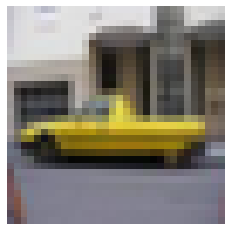

In [9]:
plt.figure(figsize = (4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

In [16]:
resized_image = tf.image.resize(images = tf.convert_to_tensor([image]), 
                                size = (image_size, image_size))
patches = Patches(patch_size = patch_size)(images = resized_image)

print(f'image size: {image_size} x {image_size}')
print(f'patch size: {patch_size} x {patch_size}')
print(f'patches per image: {patches.shape[1]}')
print(f'elements per patch: {patches.shape[-1]}')

image size: 72 x 72
patch size: 6 x 6
patches per image: 144
elements per patch: 108


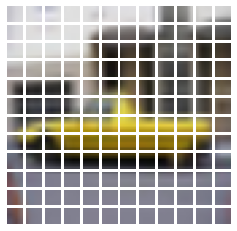

In [18]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize = (4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(tensor = patch, shape = (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

### Implement the Patch Encoding Layer

In [15]:
class PatchEncoder(layers.Layer):
  '''creates an encoded vector with the patched images'''

  def __init__(self, num_patches, projection_dim):
    '''
    class constructor

    Args:
      num_patches (int) --> number of patches in each image
      projection_dim --> number of neurons in the projection layer
    '''

    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units = projection_dim)
    self.position_embedding = layers.Embedding(
      input_dim = num_patches, output_dim = projection_dim)
  
  def call(self, patch):
    '''
    script that runs when instantiating the class
    
    Args:
      patch (array) --> images separated by patches
    
    Returns:
      encoded (tensor layer) --> vector encoded with image patches
    '''

    positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
    encoded = self.projection(patch) + self.position_embedding(positions)

    return encoded

### Build the Vision Transformer (ViT) Model


In [36]:
def create_vit_classifier(input_shape, patch_size, num_patches, 
                          transformer_layers, projection_dim, num_heads, 
                          num_classes):
  '''
  construction of the model based on vision transformer
  
  Args:
    input_shape (array) --> dimension of input images
    patch_size (int) --> size of each patch
    num_patches (int) --> number of patches per image
    projection_dim (int) --> number of neurons in the projection layer
    num_heads (int) --> heads for attention layer
    transformer_units (int) --> number of layers of the multilayer perceptron
    num_classes (int) --> number of classes to be predicted by the model
    transformer_layers (int) --> number of layers of vision transformer block

  Returns:
    model (tensor model) --> vit tensorflow model
  '''

  # image input layer
  inputs = layers.Input(shape = input_shape)
  # applying data augmentation to images
  augmented = data_augmentation(inputs)
  # layer that separates the image by patches
  patches = Patches(patch_size = patch_size)(images = augmented)
  # vector that stores image patches
  encoded_patches = PatchEncoder(num_patches = num_patches, 
                                 projection_dim = projection_dim)(patches)
  
  # create multiple layers of the transformer block
  for _ in range(transformer_layers):
    # data normalization layer
    x1 = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    # create a multi-head attention layer
    attention_output = layers.MultiHeadAttention(
      num_heads = num_heads, key_dim = projection_dim, dropout = 0.1)(x1, x1)
    # skip connection of encoded patches
    x2 = layers.Add()([attention_output, encoded_patches])
    # data normalization layer
    x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)
    # connect a multilayer perceptron
    x3 = mlp(x = x3, hidden_units = transformer_units, dropout_rate = 0.1)
    # skip connection of x2
    encoded_patches = layers.Add()([x3, x2])
  
  # create a [batch_size, projection_dim] tensor
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(rate = 0.5)(representation)
  # connect a multilayer perceptron
  features = mlp(x = representation, hidden_units = mlp_head_units, 
                 dropout_rate = 0.5)
  # classify the output data
  logits = layers.Dense(num_classes)(features)
  # create the keras model
  model = keras.Model(inputs = inputs, outputs = logits)
  
  return model

In [37]:
model = create_vit_classifier(input_shape = input_shape, 
                              patch_size = patch_size,
                              num_patches = num_patches, 
                              transformer_layers = transformer_layers,
                              projection_dim = projection_dim,
                              num_heads = num_heads, 
                              num_classes = num_classes)

### Compiling the Model

In [39]:
optimizer = tfa.optimizers.AdamW(learning_rate = learning_rate, 
                                 weight_decay = weight_decay)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric1 = keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')
metric2 = keras.metrics.SparseTopKCategoricalAccuracy(k = 5, 
                                                      name = 'top-5-accuracy')
model.compile(optimizer = optimizer, loss = loss, metrics = [metric1, metric2])

### Defining the Model Checkpoint Callback

In [41]:
checkpoint_filepath = '/tmp/checkpoint'
callback = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                           monitor = 'val_accuracy',
                                           save_best_only = True,
                                           save_weights_only = True)

### Training the Model

In [42]:
history = model.fit(x = x_train, y = y_train, batch_size = batch_size,
                    epochs = num_epochs, validation_split = 0.1,
                    callbacks = [callback])

Epoch 1/100
176/176 [==============================] - 76s 367ms/step - loss: 4.4715 - accuracy: 0.0477 - top-5-accuracy: 0.1643 - val_loss: 3.9106 - val_accuracy: 0.1138 - val_top-5-accuracy: 0.3204
Epoch 2/100
176/176 [==============================] - 65s 367ms/step - loss: 3.9397 - accuracy: 0.0944 - top-5-accuracy: 0.2922 - val_loss: 3.5816 - val_accuracy: 0.1466 - val_top-5-accuracy: 0.4054
Epoch 3/100
176/176 [==============================] - 65s 372ms/step - loss: 3.6924 - accuracy: 0.1288 - top-5-accuracy: 0.3665 - val_loss: 3.3256 - val_accuracy: 0.1942 - val_top-5-accuracy: 0.4678
Epoch 4/100
176/176 [==============================] - 66s 374ms/step - loss: 3.5127 - accuracy: 0.1616 - top-5-accuracy: 0.4191 - val_loss: 3.1966 - val_accuracy: 0.2228 - val_top-5-accuracy: 0.5084
Epoch 5/100
176/176 [==============================] - 66s 376ms/step - loss: 3.3931 - accuracy: 0.1839 - top-5-accuracy: 0.4524 - val_loss: 3.0590 - val_accuracy: 0.2408 - val_top-5-accuracy: 0.5382


### Model Evaluation Metrics

In [44]:
model.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)

print(f'Test Accuracy (100 Classes): {round(accuracy * 100, 2)}%')
print(f'Test Top 5 Classes Accuracy: {round(top_5_accuracy * 100, 2)}%')

313/313 [==============================] - 6s 21ms/step - loss: 1.8531 - accuracy: 0.5522 - top-5-accuracy: 0.8147
Test Accuracy (100 Classes): 55.22%
Test Top 5 Classes Accuracy: 81.47%
